In [42]:
import os

import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from scipy.stats import norm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from tensorflow.keras.models import Model, Sequential

In [43]:
# Konstante
normal = 0

# Versuchsparameter
training_data_ratio = 80 # in percent, remaining data will be test data
Prozent = 5
num_anomaly = 4
dataset_str = 'energy_robot_l400_s2'

# automatisch generiert
classes = [0,1,2,3,4]#list(range(num_anomaly+1))
percentage = Prozent/100
model_str = f'ae0-{num_anomaly}p{Prozent}u.hdf5'

# get the working directory of the ipykernel
working_dir = os.getcwd()

# define subdirectories
data_path = os.path.join(working_dir, "data")
xy_path = os.path.join(data_path, dataset_str)

print(model_str)
print(dataset_str)

ae0-4p5u.hdf5
energy_robot_l400_s2


In [44]:
def aursad(classes=classes):
    
    x = np.load(os.path.join(xy_path, "x.npy"))
    y = np.load(os.path.join(xy_path, "y.npy"))
    sample_nr = np.load(os.path.join(xy_path, "sample_nr.npy"))
    
    # extract the relevant classes only
    mask = [i in classes for i in y]
    x = x[mask,:,:]
    y = y[mask]
    
    # split dataset into training and test data
    split = len(y) * training_data_ratio // 100
  
    rng = np.random.default_rng(0)
    
    idx = np.arange(len(y))
    rng.shuffle(idx)
    
    train_idx = idx[:split]
    test_idx = idx[split:]
    
    x_train = x[train_idx,::]
    x_test = x[test_idx,::]
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    return (x_train, y_train), (x_test, y_test)

def prepare_curves(raw):
    """dummy method"""   
    return raw

def unsupervised(dataset="train", percentage=percentage, batch_size=64, max_size=None):
    
    x = y = None
    if (dataset == "train"):
        (x, y), (_, _) = aursad()
    elif (dataset == "test"):
        (_,_), (x,y) = aursad()
    else:
        raise ValueError("Invalid dataset specified")
        
    num_normal_samples = np.sum(y == normal)
    p = percentage * num_normal_samples / (len(y)-num_normal_samples)
    rand = np.random.rand(len(y))
   
    mask = np.logical_or(y == normal, p > rand)
    x = prepare_curves(x)[mask,:,:]
    
    total = x.shape[0]
    n = (total // batch_size) * batch_size
    
    x = x[:n,:,:]
    y = y[mask][:n]
    
    if max_size is not None:
        x = x[:max_size,:,:,:]
        y = y[:max_size]      
        
    return x, y
"""
def semi_supervised(dataset = "train", normal = normal, batch_size = 128, max_size = None):
    
    x = y = None
    if (dataset == "train"):
        (x, y), (_, _) = mnist()
    elif (dataset == "test"):
        (_,_), (x,y) = mnist()
    else:
        raise ValueError("Invalid dataset specified")
    
    x = prepare_images(x)[y == normal,:,:,:]
    
    total = x.shape[0]
    n = (total // batch_size) * batch_size
    
    x = x[:n,:,:,:]
    y = y[y == normal][:n]
    
    if max_size is not None:
        x = x[:max_size,:,:,:]
        y = y[:max_size]      
        
    return x, y

def supervised(dataset = "train", batch_size = 128, max_size = None):
    x = y = None
    if (dataset == "train"):
        (x, y), (_, _) = mnist()
    elif (dataset == "test"):
        (_,_), (x,y) = mnist()
    else:
        raise ValueError("Invalid dataset specified")
    
    x = prepare_images(x)
    
    total = x.shape[0]
    n = (total // batch_size) * batch_size
    
    x = x[:n,:,:,:]
    y = y[:n]
    
    if max_size is not None:
        x = x[:max_size,:,:,:]
        y = y[:max_size]   
    
    return x, y
"""

(x_peek, _), (_, _) = aursad()
sequence_length = x_peek.shape[1]
num_features = x_peek.shape[2]

print(f'Sequence length = {sequence_length}')
print(f'Number of features = {num_features}')

print(len(unsupervised(percentage=percentage)[0]))
print(len(aursad()[0][1]))

Sequence length = 400
Number of features = 1
1152
1632


In [45]:
latent_dim = 2
batch_size = 64
epochs = 10
epsilon_std = 1

def nll2(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    #return tf.reduce_sum(keras.losses.mean_squared_error(y_true, y_pred), axis=-1)
    mse = keras.losses.MeanSquaredError()(y_true, y_pred)
    return mse#mse(y_true, y_pred)
    #return tf.reduce_sum(keras.losses.huber(y_true, y_pred), axis=-1)
    
class ReconstructionLossLayer(Layer):
    
    def __init__(self, loss=None, *args, **kwargs):
        super(ReconstructionLossLayer, self).__init__(*args, **kwargs)

        if loss is None:
            self.loss_func = lambda x_true, x_pred: 0
        elif type(loss) == str:
            loss = loss.lower()         
            if loss == "mae":
                self.loss_func = tf.keras.losses.MeanAbsoluteError()
            elif loss == "mse":
                self.loss_func = tf.keras.losses.MeanSquaredError()
            elif loss == "huber":
                self.loss_func = tf.keras.losses.Huber()
            else:
                raise ArgumentError("Invalid loss function:", loss)
        else:
            raise ArgumentError("Loss function must be a str")
            
        self.loss = loss

    def call(self, inputs):
        """
        Computes the reconstruction loss of x_pred with respect to x_true.
    
        Parameters
        ----------
    
        inputs : tuple or list
            A two-element tuple or list of the original and the predicted representation
            
        Returns
        -------
        x_pred
            The predicted representation
        """
        
        # unzip the inputs
        x_true, x_pred = inputs
        
        # compute the loss
        loss = self.loss_func(x_true, x_pred)

        # add the computed loss and set the loss metric
        self.add_loss(loss)
        self.add_metric(loss, "Reconstr.Loss")

        return x_pred
    
    def get_config(self):
        config = {
            'loss': self.loss,
        }
        return config
    
class ContextVectorSamplingLayer(Layer):
    
    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(ContextVectorSamplingLayer, self).__init__(*args, **kwargs)
    
    def call(self, inputs):
        c_mean, c_log_var = inputs
        
        epsilon = tf.random.normal(shape=tf.shape(c_mean)) * epsilon_std
        return c_mean + tf.exp(0.5*c_log_var) * epsilon
    
class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, kl_name="unknown", num_axis=1, weight=1, *args, **kwargs):
        self.is_placeholder = True
        self.num_axis = num_axis
        self.weight = weight
        self.kl_name = kl_name
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = -0.5 * tf.reduce_sum(1 + log_var -
                                tf.square(mu) -
                                tf.exp(log_var), axis=-1)
        
        if self.num_axis > 1:
            kl_batch = tf.reduce_sum(kl_batch, axis=-1)
        print(f"KL.shape={kl_batch.shape}")
        
        kl_div_loss = self.weight * tf.reduce_mean(kl_batch)

        self.add_loss(kl_div_loss)
        self.add_metric(kl_div_loss, f"KL-{self.kl_name}")

        return inputs
    
    def get_config(self):
        config = {
            'kl_name': self.kl_name,
            'weight': self.weight,
        }
        return config
    
# feature filters multiplier: considers multivariate data
ff = 1
if num_features > 2:
    ff = num_features 
    
encoder_input = keras.Input(shape=(sequence_length, num_features), name = "encoder-input")
    
"""
decoder = Sequential([    
    Dense(11 * 64, input_dim=latent_dim, activation="relu"),
    layers.Reshape((11, 64)),
    layers.UpSampling1D(size=3),
    layers.Conv1DTranspose(filters=32, kernel_size=9, activation="relu"),
    layers.UpSampling1D(size=3),
    layers.Conv1DTranspose(filters=16, kernel_size=9, activation="relu"),
    layers.UpSampling1D(size=3),
    layers.Conv1DTranspose(filters=8, kernel_size=5, activation="relu"),
    layers.UpSampling1D(size=2),
    layers.Conv1DTranspose(filters=1, kernel_size=7, activation="sigmoid"),
], name = "Decoder")
"""

################# CNN-AE: Stride downsampling

"""
decoder = Sequential([    
    Dense(14 * 64, input_dim=latent_dim, activation="relu"),
    layers.Reshape((14,64)),
    layers.Conv1DTranspose(filters=32*ff, kernel_size=5, strides=2, padding="valid", activation="relu"),
    #layers.Dropout(0.2),
    layers.Conv1DTranspose(filters=16*ff, kernel_size=5, strides=2, activation="relu"),
    layers.Conv1DTranspose(filters=8*ff, kernel_size=5, strides=2, activation="relu"),
    #layers.BatchNormalization(axis=1),
    layers.Conv1DTranspose(filters=num_features, kernel_size=4, strides=3, padding="valid", output_padding=0, activation="relu"),
], name = "Decoder")

encoder = keras.models.Sequential([
    keras.layers.Conv1D(filters=8*ff, kernel_size=9, strides=3, activation="relu"),
    #keras.layers.Dropout(0.2),
    keras.layers.Conv1D(filters=16*ff, kernel_size=7, strides=2, activation="relu"),
    keras.layers.Conv1D(filters=32*ff, kernel_size=5, strides=2, activation="relu"),
    keras.layers.Conv1D(filters=64*ff, kernel_size=5, strides=2, activation="relu"),
    keras.layers.Flatten(),
    keras.layers.Dense(16, activation="relu"),
    Dense(latent_dim),
], name="Encoder")
"""

############# CNN-AE - Pooling Downsampling ##############

"""
encoder = Sequential([
    layers.Conv1D(filters=8, kernel_size=7, activation="relu"),
    layers.MaxPool1D(pool_size=3),
    layers.Conv1D(filters=16, kernel_size=7, activation="relu"),
    layers.MaxPool1D(pool_size=3),
    layers.Conv1D(filters=32, kernel_size=5, activation="relu"),
    layers.MaxPool1D(pool_size=3),
    layers.Conv1D(filters=64, kernel_size=5, activation="relu"),
    layers.MaxPool1D(pool_size=3),
    layers.Flatten(),
    layers.Dense(16, activation="relu"),
], name="Encoder")
"""

"""
x = layers.Conv1D(filters=8, kernel_size=7, activation="relu")(encoder_input)
x = layers.MaxPool1D(pool_size=3)(x)
x = layers.Conv1D(filters=16, kernel_size=7, activation="relu")(x)
x = layers.MaxPool1D(pool_size=3)(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.MaxPool1D(pool_size=3)(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu")(x)
x = layers.MaxPool1D(pool_size=3)(x)
x = layers.Flatten()(x)
h = layers.Dense(16, activation="relu")(x)
"""

################# LSTM - Autoencoder #####################
"""
encoder = keras.models.Sequential([
    keras.layers.LSTM(32,return_sequences=True),
    keras.layers.LSTM(16),
    keras.layers.Dense(latent_dim, activation="relu")
], name="Encoder")

decoder = Sequential([    
    Dense(16, input_dim=latent_dim, activation="relu"),
    keras.layers.RepeatVector(sequence_length),
    keras.layers.LSTM(16, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.TimeDistributed(Dense(num_features)),
], name = "Decoder")
"""

################# CNN-LSTM - Autoencoder #####################
"""
encoder = keras.models.Sequential([
    keras.layers.Conv1D(filters=8, kernel_size=5, strides=2, activation="relu", padding="same"),
    keras.layers.Conv1D(filters=16, kernel_size=5, strides=2, activation="relu", padding="same"),
    #keras.layers.LSTM(32,return_sequences=True),
    #keras.layers.LSTM(16),
    #keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=False),
    keras.layers.Dense(latent_dim, activation="relu")
], name="Encoder")

decoder = Sequential([    
    Dense(32, activation="relu"),
    #keras.Input(shape=(32,)),
    keras.layers.RepeatVector(sequence_length//4),
    #keras.layers.LSTM(16, return_sequences=True),
    #keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=True),
    #keras.layers.TimeDistributed(Dense(num_features)),
    keras.layers.Conv1DTranspose(filters=16, kernel_size=5, strides=2, activation="relu", padding="same"),
    keras.layers.Conv1DTranspose(filters=num_features, kernel_size=5, strides=2, activation="relu", padding="same"),
    
], name = "Decoder")
"""

################# CNN-LSTM + Dot-Product Attention - Autoencoder #####################
"""
encoder = keras.models.Sequential([
    keras.layers.Conv1D(filters=8, kernel_size=5, strides=2, activation="relu", padding="same"),
    keras.layers.Conv1D(filters=16, kernel_size=5, strides=2, activation="relu", padding="same"),
    keras.layers.LSTM(32, return_sequences=True),
], name="Encoder")

decoder = Sequential([    
    #Dense(32, activation="relu"),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Conv1DTranspose(filters=16, kernel_size=5, strides=2, activation="relu", padding="same"),
    keras.layers.Conv1DTranspose(filters=num_features, kernel_size=5, strides=2, activation="relu", padding="same"),
    
], name = "Decoder")
"""

################# WaveNet Autoencoder #######################
"""3"""
encoder = keras.models.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, dilation_rate=2, activation="relu", padding="causal"),
    keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, dilation_rate=2, activation="relu", padding="causal"),
    keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, dilation_rate=2, activation="relu", padding="causal"),
    keras.layers.MaxPool1D(4),
    keras.layers.Flatten(),
    keras.layers.Dense(latent_dim, activation="relu")
], name="Encoder")

decoder = Sequential([    
    Dense(10*32, input_dim=latent_dim, activation="relu"),
    keras.layers.Reshape((10,32)),
    keras.layers.UpSampling1D(5),
    keras.layers.Conv1DTranspose(filters=32, kernel_size=5, strides=2, activation="relu", padding="same"),
    keras.layers.Conv1DTranspose(filters=16, kernel_size=5, strides=2, activation="relu", padding="same"),
    keras.layers.Conv1DTranspose(filters=num_features, kernel_size=5, strides=2, activation="relu", padding="same"),
], name = "Decoder")
"""3"""

z = encoder(encoder_input)
z2 = z
hidden_decoder=z

"""
############### Dot Product Attention ######################

from tensorflow.python.ops import math_ops

class SelfAttention(keras.layers.Layer):
    
    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(SelfAttention, self).__init__(*args, **kwargs)

    def call(self, inputs):
        
        # scores
        print(f"inputs.shape={inputs.shape}")
        scores = tf.matmul(inputs, inputs, transpose_b=True)
        print(f"scores.shape={scores.shape}")
        
        # Scale
        dk = inputs.shape[-2]
        scores /= dk
        
        # Softmax
        scores = tf.nn.softmax(scores, axis=-1)
        
        # context vector  
        context = tf.matmul(scores, inputs)
        print(f"context.shape={context.shape}")
        
        return inputs, scores
    

# context_vector
c_det, attention_scores = SelfAttention()(z)
# variational self-attention
c_mu = keras.layers.Dense(latent_dim, activation="relu")(c_det)
c_sigma = keras.layers.Dense(latent_dim, activation="relu")(c_det)
c_mu, c_sigma = KLDivergenceLayer(kl_name="attention", num_axis=2, weight=0.1)([c_mu, c_sigma])
c = ContextVectorSamplingLayer()([c_mu, c_sigma])

z = keras.layers.Flatten()(z)
#z = keras.layers.Dense(16, activation="relu")(z)
z_mu = keras.layers.Dense(latent_dim, activation="relu")(z)
z_log_var= keras.layers.Dense(latent_dim, activation="softplus")(z)
z_mu, z_log_var = KLDivergenceLayer(kl_name="z", num_axis=1, weight=0.05)([z_mu, z_log_var])
z2 = ContextVectorSamplingLayer()([z_mu, z_log_var])
#z2=keras.layers.Dense(latent_dim)(z)

hidden_decoder = keras.layers.RepeatVector(sequence_length//4)(z2)
hidden_decoder = keras.layers.Concatenate()([c,hidden_decoder]) 
print(z.shape)
"""

############################################################

x_pred=decoder(hidden_decoder)

x_pred = ReconstructionLossLayer(loss="mse")([encoder_input, x_pred])

ae = Model(inputs=encoder_input, outputs=x_pred, name="ae-model")
ae.compile(optimizer="adam")
ae.summary()
encoder.summary()
decoder.summary()

Model: "ae-model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder-input (InputLayer)      [(None, 400, 1)]     0                                            
__________________________________________________________________________________________________
Encoder (Sequential)            (None, 2)            16898       encoder-input[0][0]              
__________________________________________________________________________________________________
Decoder (Sequential)            (None, 400, 1)       8769        Encoder[0][0]                    
__________________________________________________________________________________________________
reconstruction_loss_layer_2 (Re (None, 400, 1)       0           encoder-input[0][0]              
                                                                 Decoder[0][0]             

In [46]:
# train the VAE on MNIST digits
training_data, _ = unsupervised()
print(training_data.shape)

callbacks = [keras.callbacks.ModelCheckpoint(
        monitor = 'loss',
        filepath = model_str, 
        save_weights_only = False,
        save_best_only = False)]

#ae.load_weights(model_str)
history = ae.fit(training_data, epochs=50, shuffle = True, batch_size=batch_size, callbacks = callbacks)
        #validation_data=(validation_data, validation_data)
#vae.load_weights(model_str)

(1152, 400, 1)
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
18/18 [==============================] - 1s 24ms/step - loss: 0.4583 - Reconstr.Loss: 0.3927
Epoch 2/50
18/18 [==============================] - 0s 24ms/step - loss: 0.1312 - Reconstr.Loss: 0.0816
Epoch 3/50
18/18 [==============================] - 0s 24ms/step - loss: 0.0159 - Reconstr.Loss: 0.0138
Epoch 4/50
18/18 [=====================

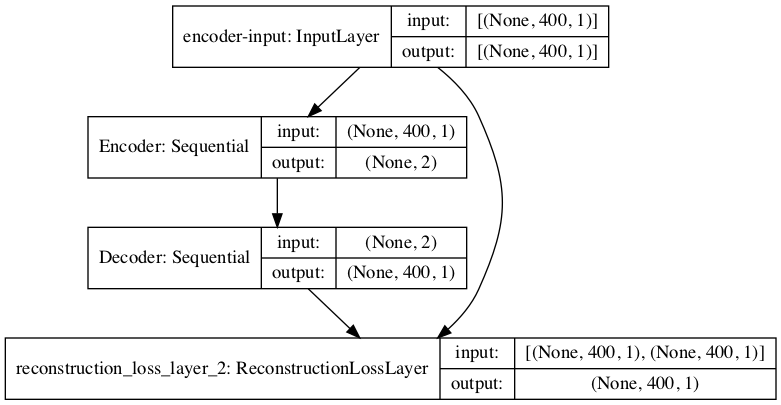

In [47]:
keras.utils.plot_model(ae, show_shapes = True)

### Aktives Lernen - Entkoppelter Ansatz
Der Klassifikator wird auf den Ausgaben des Encoders trainiert, ohne dass die Parametrierung des Encoders im Laufe des Trainings angepasst wird

In [48]:
#mu_input = Input(shape=(latent_dim))
#log_var_input = Input(shape=(latent_dim))

#vae_al_input = layers.Concatenate()([mu_input, log_var_input])
#hidden = Dense(8, activation = "relu")(vae_al_input)
#hidden = Dense(8, activation = "relu")(hidden)
#y_pred = Dense(1, activation = "sigmoid")(hidden)

#vae_al = Model(inputs = [mu_input, log_var_input], outputs=y_pred, name="vae-active-learning")
#vae_al.compile(optimizer="adam", loss="binary_crossentropy")
#vae_al.summary()

### Aktives Lernen - Rückkopplung zum Encoder
Der Klassifikator wird als weitere Schicht auf den Encoder aufgesetzt und beeinflusst so dessen Parameter während des Trainings

In [49]:
#vae_al_input = layers.Concatenate()([z_mu, z_log_var])
#hidden = Dense(8, activation = "relu")(vae_al_input)
#hidden = Dense(8, activation = "relu")(hidden)
#y_pred = Dense(1, activation = "sigmoid")(hidden)

#vae_al = Model(inputs = encoder_input, outputs=y_pred, name="vae-active-learning")
#vae_al.compile(optimizer="adam", loss="binary_crossentropy")
#vae_al.summary()

### Aktives Lernen - Feedback für das Gesamtmodell
Im unüberwachten Szenario ist der Verlust unverändert, im überwachten Szenario wird auf den Verlus der BinaryCrossEntropyLoss des Klassifikator aufaddiert

In [50]:
score_scaled = layers.Lambda(lambda x: x*0/100, name="score-scaling")(score)
score_vec = layers.Reshape((1,))(score_scaled)
interface = layers.Concatenate()([z_mu, z_log_var, score_vec])
hidden = Dense(8, activation = "relu")(interface)
hidden = Dense(8, activation = "relu")(hidden)
y_pred = Dense(1, activation = "sigmoid")(hidden)

vae_al = Model(inputs=encoder_input, outputs=y_pred, name="vae-active-learning")
vae_al.compile(optimizer="adam", loss="binary_crossentropy")
#vae_al.summary()

NameError: name 'score' is not defined

In [51]:
#keras.utils.plot_model(vae_al, show_shapes = True)

In [52]:
def attention_visualizer():
    
    (orig, _), (_, _) = aursad()
    
    attention_vis = Model(inputs=encoder_input, outputs=attention_scores)
    
    scores = attention_vis.predict(orig[:batch_size,:,:])[0,:,:]
    scores = np.log(scores)
    print("scores: ",scores.shape)
    #plt.imshow(scores, cmap='hot', interpolation='nearest')
    #plt.show()
    
    n = scores.shape[0]
    n = n//10
    
    print(np.sum(scores, axis=1))
    
    fig, (ax1, ax2) = plt.subplots(1,2,gridspec_kw={'width_ratios': [3, 1]}, figsize=(10,6))
    im = ax1.imshow(scores)
    
    ax1.set_xticks(np.arange(10)*n)
    ax1.set_yticks(np.arange(10)*n)

    # Loop over data dimensions and create text annotations.
    for i in range(10):
        for j in range(10):
            text = ax1.text(j*n, i*n, np.round(scores[i*n, j*n],2), ha="center", va="center", color="w")

    ax1.set_title("Attention heat map")
    
    ax2.plot(orig[0,:,0],-np.arange(0,len(orig[0,:,0])))
    ax2.set_ylim(-len(orig[0,:,0]),0)
    
    fig.tight_layout()
    plt.show()
   
attention_visualizer()

NameError: name 'attention_scores' is not defined

In [53]:
ae_encoder = Model(inputs = encoder_input, outputs=hidden_decoder)
#keras.utils.plot_model(encoder)

408
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
10.0
10
10


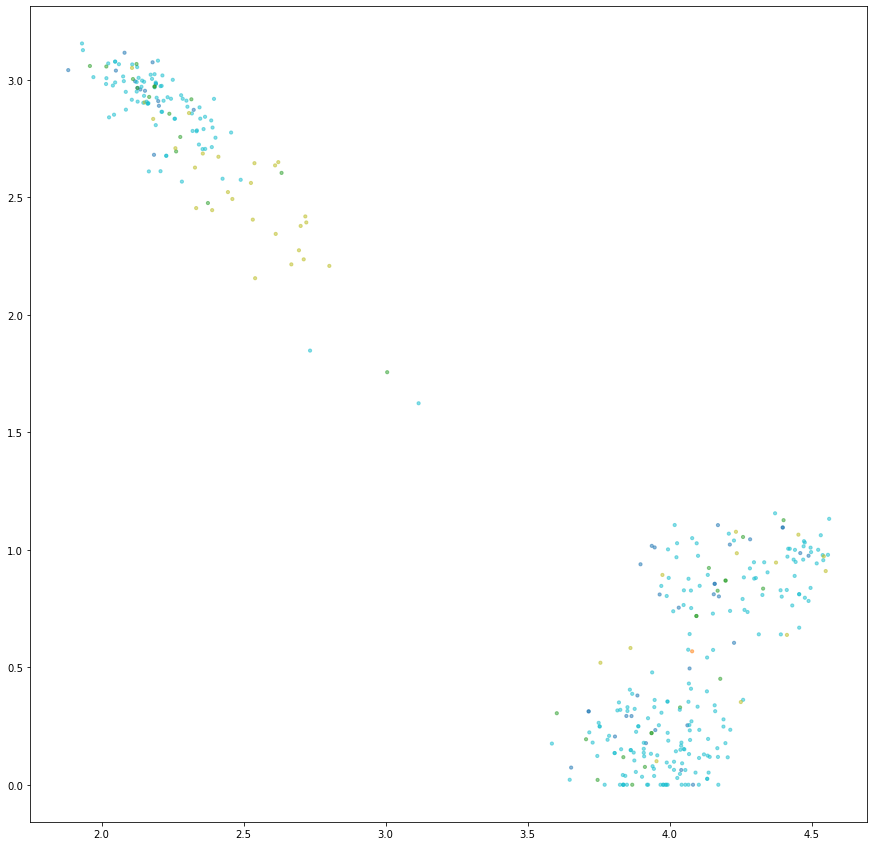

In [54]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_latent_space(vae, include_labels=[i for i in range(10)], show_size = True):
    
    (_, _), (x_test, y_test) = aursad()
    #(x_test, y_test), (_, _) = aursad()
    print(len(y_test))
    
    encoder = Model(inputs = encoder_input, outputs =z)
    
    def color_from_label(labels):
        l2c = {0:'tab:cyan',
               1:'tab:blue',
               2:'tab:green',
               3:'tab:olive',
               4:'tab:orange',
               5:'tab:red',
               6:'tab:brown',
               7:'tab:purple',
               8:'tab:pink',
               9:'tab:gray',
              }
        return [l2c[label] for label in labels]
    
    idx = [i in include_labels for i in y_test]
    
    l = len(idx) // batch_size
    
    x = prepare_curves(x_test)[idx,:,:][:batch_size*l,::]
    labels = y_test[idx][:batch_size*l]
    z_val = encoder.predict_on_batch(x)
    latent_x = z_val[:,0]
    latent_y = z_val[:,1]
    latent_size = 10
    if show_size:
        pass
        #latent_size = np.mean(np.exp(z[1]),axis = 1) * 300
    
    print(np.mean(latent_size))
    print(np.max(latent_size))
    print(np.min(latent_size))
    
    plt.figure(figsize=(15,15))
    plt.scatter(latent_x, latent_y, s=latent_size, c=color_from_label(labels), alpha=0.5)

    
visualize_latent_space(None)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


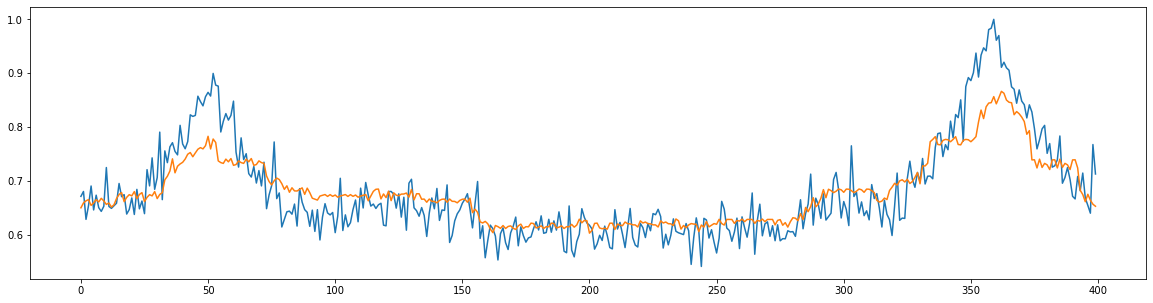

In [55]:
def reconstruction(sample=0, feature=0):
    
    (orig, _), (_, _) = aursad()

    orig = orig[sample,:,:]
     
    fig = plt.figure(figsize=(20,5))    
    plt.plot(orig[:,feature])
    
    x_pred = ae.predict(orig.reshape((1,sequence_length,num_features)))
    plt.plot(x_pred.reshape((-1,num_features))[:,feature])
    plt.show()


reconstruction()

In [56]:
def mahalanobis_anomaly_score(x_true, x_pred):
    
    a = np.zeros((x_true.shape[0], x_true.shape[1]))
    for t in range(x_true.shape[1]):
        
        xt_true = x_true[:,t,:]
        xt_pred = x_pred[:,t,:]
        
        error = np.abs(xt_true-xt_pred)
    
        mu = np.mean(error, axis=0)
        #print(mu.shape)
        
        cov = np.cov(error, rowvar=False)
        inv_cov = np.linalg.inv(cov)
        #print(cov.shape)
        
        for s in range(x_true.shape[0]):
            e = error[s,:]

            a[s,t] = np.matmul(np.matmul((e-mu).T, inv_cov),(e-mu))
        
    return a

def show_anomaly_score(sample=0, label=0):
    
    (orig, y), (_, _) = aursad()
    
    x_pred = ae.predict(orig)

    #z = ae_encoder.predict(orig)
    #x_pred = np.zeros(orig.shape)
    #x_pred[:,:400,:] = decoder.predict(z)

    a = mahalanobis_anomaly_score(orig, x_pred)
    
    s = 0
    while y[s] != label:
        s+=1
        
            
    num_plots = orig.shape[2]+1
    fig, ax = plt.subplots(num_plots,1,figsize=(15,num_plots*3))
        
    for i, axi in enumerate(ax):
            
        if axi != ax[-1]:
            axi.plot(orig[s,:,i])
            axi.plot(x_pred[s,:,i])
        else:
            break
        
    ax[-1].plot(a[s,:], c="r")
    ax[-1].hlines(np.mean(a[s,:]), 0,400)
    ax[-1].legend(["mahalanobis", str(np.mean(a[s,:]))])
    plt.show()
        
show_anomaly_score()

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

In [57]:
def load_vae(path):
    mapping = {
        "KLDivergenceLayer": KLDivergenceLayer,
        "SampleLayer": SampleLayer,
        "ReconstructionLossLayer": ReconstructionLossLayer,
    }
    vae = keras.models.load_model(path, custom_objects = mapping)
    return vae

(1152, 400, 1)
0.003377834944826781


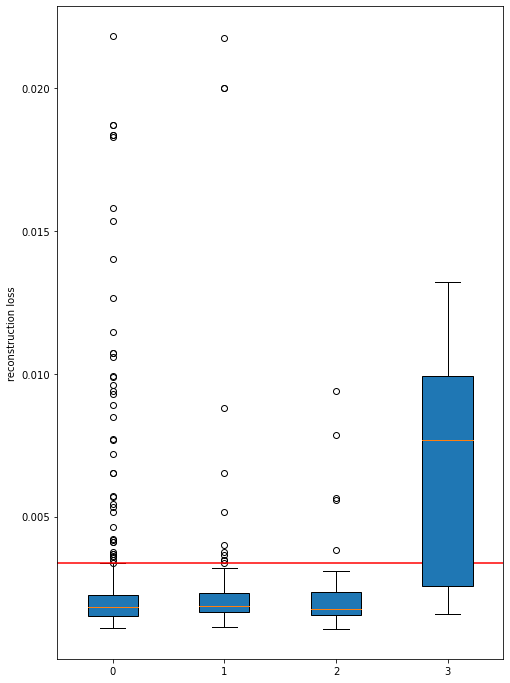

In [58]:
def mse(x_true, x_pred):
        
        loss = np.mean((x_true-x_pred)**2, axis=1)
        loss = np.mean(loss, axis=-1)
        return loss
    
def mae(x_true, x_pred):
    loss = np.mean(np.abs(x_true-x_pred), axis=1)
    loss = np.mean(loss, axis=-1)
    return loss

def anomaly_detection(vae, loss_func=mae):
    
    #(_, _), (x_test, y_test) = aursad()
    (x_test, y_test), (_, _) = aursad()
    
    def color_from_label(labels):
        l2c = {0:'tab:cyan',
               1:'tab:blue',
               2:'tab:green',
               3:'tab:olive',
               4:'tab:orange',
               5:'tab:red',
               6:'tab:brown',
               7:'tab:purple',
               8:'tab:pink',
               9:'tab:gray',
              }
        return [l2c[label] for label in labels]
    
    labels = [i for i in range(4)]
    
    all_loss = list()   
    for label in labels:
        x = prepare_curves(x_test)[y_test == label,:,:]
        if x.shape[0] == 0:
            all_loss.append([0])
            continue
            
        decoded = ae.predict(x)
        
        loss = loss_func(x, decoded)
        all_loss.append(loss.reshape(-1))
    
    fig, ax = plt.subplots(figsize=(8,12))
    ax.boxplot(all_loss,
        vert=True,  # vertical box alignment
        patch_artist=True,  # fill with color
        labels=labels)
    ax.set_ylabel("reconstruction loss")
    
    x_train, _ = unsupervised(dataset = "train")
    print(x_train.shape)
    
    x_pred = ae.predict(x_train)
    training_loss = loss_func(x_train, x_pred)

    critical_anomaly_score = np.quantile(training_loss, 0.95)
    print(critical_anomaly_score)
    
    ax.axhline(critical_anomaly_score, color="r")

#my_vae = load_vae(model_str)
anomaly_detection(ae, loss_func=mse)

In [59]:
def baseline_ad(model = "unsupervised", loss_func=mse):
    
    x_train = None
    if model == "unsupervised":
        x_train, _ = unsupervised(dataset = "train")
    else:
        #x_train_normal, _ = semi_supervised(dataset = "train", normal = normal)
        assert False
        
    x_pred = ae.predict(x_train)
    training_loss = loss_func(x_train, x_pred)    
        
    critical_anomaly_score = np.quantile(training_loss, 0.95)
    
    print(f'Critical Anomaly Score = {critical_anomaly_score}')
    
    (_,_), (x_test, y_test) = aursad()
    
    for i in range(5):
        count = np.sum(y_test==i)
        print(f'Anzahl {i}: {count}')
    
    x_test_pred = ae.predict(x_test)
    test_loss = loss_func(x_test, x_test_pred)    
    
    predicted = test_loss > critical_anomaly_score
    actual = y_test != 0
    
    # positiv = anomalous, negative = normal
    tp = np.sum(np.logical_and(actual == 1, predicted == 1))
    tn = np.sum(np.logical_and(actual == 0, predicted == 0))
    fp = np.sum(np.logical_and(actual == 0, predicted == 1))
    fn = np.sum(np.logical_and(actual == 1, predicted == 0))
    n = len(y_test)
    
    print(f'TP = {tp}, TN = {tn}, FP = {fp}, FN = {fn}, N = {n}')
    
    accuracy = (tp+tn) / n
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f'Accuracy = {accuracy}, F1 = {f1}, precision = {precision}, recall = {recall}')
    
    
baseline_ad(loss_func=mae)

Critical Anomaly Score = 0.04254332131285725
Anzahl 0: 284
Anzahl 1: 45
Anzahl 2: 37
Anzahl 3: 41
Anzahl 4: 1
TP = 40, TN = 277, FP = 7, FN = 84, N = 408
Accuracy = 0.7769607843137255, F1 = 0.46783625730994155, precision = 0.851063829787234, recall = 0.3225806451612903


### Query Strategy

In [19]:
def naive_query(budget, normal = 0):
    x_query, y_query = supervised(dataset = "train", max_size = budget)
    y_query = y_query != normal     
    return x_query, y_query
    
def edgecase_query(budget, normal = 0):
    x, y = unsupervised(dataset = "train", max_size = None)
    y = y != normal
    
    baseline_model = load_vae(model_str)
    loss = baseline_model.predict(x)
    critical_anomaly_score = np.quantile(loss, 0.90)    
    print(f'Critical Anomaly score: {critical_anomaly_score}')
        
    edge_cases = np.abs(loss - critical_anomaly_score)
        
    idx = np.argsort(edge_cases)
    idx = idx[:budget]
        
    return x[idx, :,:,:], y[idx]
    
    
def edgecase_query_plus(budget, normal = 0):
    x, y = unsupervised(dataset = "train", max_size = None)
    y = y != normal
    
    baseline_model = load_vae(model_str)
    loss = baseline_model.predict(x)
    critical_anomaly_score = np.quantile(loss, 0.90)    
    print(f'Critical Anomaly score: {critical_anomaly_score}')
        
    edge_cases = loss - critical_anomaly_score
        
    # reduce x and y
    x = x[edge_cases > 0]
    y = y[edge_cases > 0]
    edge_cases = edge_cases[edge_cases > 0] # only select more anomalous examples
        
    idx = np.argsort(edge_cases)
    idx = idx[:budget]
        
    return x[idx, :,:,:], y[idx]
    
def most_anomalous_query(budget, normal = 0):
    x, y = unsupervised(dataset = "train", max_size = None)
    y = y != normal
    
    baseline_model = load_vae(model_str)
    loss = baseline_model.predict(x)
        
    idx = np.argsort(loss)
    idx = idx[-budget:]
        
    return x[idx, :,:,:], y[idx]

In [20]:
def active_learning_decoupled(normal = 0):
    """Enhance the prediction accuracy by retraining the model with the top-k most intersting samples in a
    supervised fashion.
        1) Find the top-k samples and get their labels
        2) Retrain the model with these samples in a supervised fashion -> prevent overfitting
        3) Evaluate accuracy, F1-score, ..."""
    
    budget = batch_size  
    
    x_query, y_query = most_anomalous_query(budget)
    print(np.sum(y_query))
    
    callbacks = [keras.callbacks.ModelCheckpoint(
        monitor = 'loss',
        filepath = 'vae_al0-{epoch:02d}.hdf5', 
        save_weights_only = False,
        save_best_only = False)]
    
    z_query = encoder.predict(x_query)

    history = vae_al.fit(z_query, y_query, shuffle = True, epochs=100, batch_size=32)
        #training_data,
        #shuffle=True,      
     #   callbacks = callbacks,
      #  validation_data = (x_valid, y_valid))
    
    x_test, y_test = supervised(dataset = "test")
    z_test = encoder.predict(x_test)
    
    predicted = vae_al.predict(z_test).reshape((-1)) > 0.5
    actual = y_test != normal
    
    # positiv = anomalous, negative = normal
    tp = np.sum(np.logical_and(actual == 1, predicted == 1))
    tn = np.sum(np.logical_and(actual == 0, predicted == 0))
    fp = np.sum(np.logical_and(actual == 0, predicted == 1))
    fn = np.sum(np.logical_and(actual == 1, predicted == 0))
    n = len(y_test)
    
    print(f'TP = {tp}, TN = {tn}, FP = {fp}, FN = {fn}, N = {n}')
    
    accuracy = (tp+tn) / n
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f'Accuracy = {accuracy}, F1 = {f1}, precision = {precision}, recall = {recall}')
    
#active_learning_decoupled()

In [21]:
def active_learning_encoderfeedback(normal = 0):
    budget = batch_size  
    
    x_query, y_query = most_anomalous_query(budget)
    print(np.sum(y_query))
    
    callbacks = [keras.callbacks.ModelCheckpoint(
        monitor = 'loss',
        filepath = 'vae_al_ef0-{epoch:02d}.hdf5', 
        save_weights_only = False,
        save_best_only = False)]

    history = vae_al.fit(x_query, y_query, shuffle = True, epochs=50, batch_size=32)
    
    x_test, y_test = supervised(dataset = "test")
    
    predicted = vae_al.predict(x_test).reshape(-1) > 0.5
    actual = (y_test != normal)
    
    # positiv = anomalous, negative = normal
    tp = np.sum(np.logical_and(actual == 1, predicted == 1))
    tn = np.sum(np.logical_and(actual == 0, predicted == 0))
    fp = np.sum(np.logical_and(actual == 0, predicted == 1))
    fn = np.sum(np.logical_and(actual == 1, predicted == 0))
    
    print(f'TP = {tp}, TN = {tn}, FP = {fp}, FN = {fn}, N = {n}')
    
    accuracy = (tp+tn) / n
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f'Accuracy = {accuracy}, F1 = {f1}, precision = {precision}, recall = {recall}')
    
#active_learning_encoderfeedback()

In [22]:
def active_learning_modelfeedback(normal = 0):
    budget = batch_size 
    
    x_query, y_query = most_anomalous_query(budget)
    print(np.sum(y_query))
    
    callbacks = [keras.callbacks.ModelCheckpoint(
        monitor = 'loss',
        filepath = 'vae_al_ef0-{epoch:02d}.hdf5', 
        save_weights_only = False,
        save_best_only = False)]

    history = vae_al.fit(x_query, y_query, shuffle = True, epochs=60, batch_size=32)
    
    x_test, y_test = supervised(dataset = "test")
    
    predicted = vae_al.predict(x_test).reshape(-1) > 0.5
    actual = (y_test != normal)
    
    # positiv = anomalous, negative = normal
    tp = np.sum(np.logical_and(actual == 1, predicted == 1))
    tn = np.sum(np.logical_and(actual == 0, predicted == 0))
    fp = np.sum(np.logical_and(actual == 0, predicted == 1))
    fn = np.sum(np.logical_and(actual == 1, predicted == 0))
    n = len(actual)
    
    print(f'TP = {tp}, TN = {tn}, FP = {fp}, FN = {fn}, N = {n}')
    
    accuracy = (tp+tn) / n
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    f1 = 2 * precision * recall / (precision + recall)
    print(f'Accuracy = {accuracy}, F1 = {f1}, precision = {precision}, recall = {recall}')
    
active_learning_modelfeedback()

NameError: name 'SampleLayer' is not defined

In [ ]:
visualize_latent_space(None, show_size = True)
anomaly_detection(vae)